## this code...

- downloads parliamentary speech corpus in 2020, delete comments from text
- downloads the names and party of representatives from 2018 to 2020
- downloads voting outcomes of the 2018 hungarian parliamentary elections

NOTE: media outlet coprus is added independently

## import necessary packages

In [1]:
import pandas as pd
import numpy as np
import re
import requests
import json
from bs4 import BeautifulSoup
from tqdm import tqdm
from gzip import decompress
from json import loads
from requests import get

tqdm.pandas()
data_dir = "/Users/vigadam/Dropbox/github/media_network/media_data/media-parliament-scaling/data/"

## download and clean 2020 parliament text

I asked for data at Kmonitor, they built this [project](https://k-monitor.github.io/parliamentary_debates_open/) and already scraped raw data from parliament website.

In [2]:
corpus_urls = [
    "https://parldatastorage.blob.core.windows.net/parldata-crawler-results/parldata-41.2019-10-23T15-03-10.json.gz",
    "https://parldatastorage.blob.core.windows.net/parldata-crawler-results/parldata-41.2020-01-14T19-25-52.json.gz",
    "https://parldatastorage.blob.core.windows.net/parldata-crawler-results/parldata-41.2020-11-29T14-11-09.json.gz",
]

In [3]:
def get_gzipped_json(url):
    return loads(decompress(get(url).content))

download data

In [5]:
parldata = pd.DataFrame()
for url in corpus_urls:
    chunk = pd.DataFrame(get_gzipped_json(url))
    chunk["date"] = chunk["plenary_sitting_details"].apply(lambda x: x["date"])
    parldata = pd.concat(
        [parldata, chunk.sort_values(by=["date", "id"]).reset_index(drop=True)]
    )

In [6]:
parldata.head()

,speaker,topic,url,video_url,text,speaker_url,prev_speech_url,speaker_party,id,type,duration,plenary_sitting_details,next_speech_url,bill_url,bill_title,started_at,committee,date
0,Dr. Latorcai János,Ülésnap megnyitása,https://www.parlament.hu/internet/plsql/ogy_na...,https://sgis.parlament.hu/archive/playseq.php?...,"ELNÖK : (A teremben lévők felállnak, és ezzel ...",https://www.parlament.hu/internet/plsql/ogy_kp...,NaN,KDNP,41-70-1,Az ülésnap megnyitása,0:44,"{'sitting_id': '25', 'day': 'kedd', 'duration_...",https://www.parlament.hu/internet/plsql/ogy_na...,NaN,NaN,NaN,NaN,2019.06.11.
1,Dr. Hiller István,"[Napirend előtti felszólalások, A Magyar Tudom...",https://www.parlament.hu/internet/plsql/ogy_na...,https://sgis.parlament.hu/archive/playseq.php?...,DR. HILLER ISTVÁN (MSZP): Tisztelt Elnök Úr! K...,https://www.parlament.hu/internet/plsql/ogy_kp...,https://www.parlament.hu/internet/plsql/ogy_na...,MSZP,41-70-10,napirend előtti felszólalás,5:11,"{'sitting_id': '25', 'day': 'kedd', 'duration_...",https://www.parlament.hu/internet/plsql/ogy_na...,NaN,NaN,13:24:00,NaN,2019.06.11.
2,Dr. Rétvári Bence,Kérdés/azonnali kérdés megtárgyalása,https://www.parlament.hu/internet/plsql/ogy_na...,https://sgis.parlament.hu/archive/playseq.php?...,"DR. RÉTVÁRI BENCE, az Emberi Erőforrások Minis...",https://www.parlament.hu/internet/plsql/ogy_kp...,https://www.parlament.hu/internet/plsql/ogy_na...,KDNP,41-70-100,azonnali kérdésre adott miniszteri viszonválasz,1:09,"{'sitting_id': '25', 'day': 'kedd', 'duration_...",https://www.parlament.hu/internet/plsql/ogy_na...,[https://www.parlament.hu/internet/plsql/ogy_i...,[A/6443 Magyarországon többen halnak meg kór...,15:59:00,Emberi Erőforrások Minisztériumának államtitkára,2019.06.11.
3,Jakab István,Kérdés/azonnali kérdés megtárgyalása,https://www.parlament.hu/internet/plsql/ogy_na...,https://sgis.parlament.hu/archive/playseq.php?...,ELNÖK: Megköszönöm államtitkár úr válaszát. Ti...,https://www.parlament.hu/internet/plsql/ogy_kp...,https://www.parlament.hu/internet/plsql/ogy_na...,Fidesz,41-70-101,ülésvezetés,0:26,"{'sitting_id': '25', 'day': 'kedd', 'duration_...",https://www.parlament.hu/internet/plsql/ogy_na...,[https://www.parlament.hu/internet/plsql/ogy_i...,[A/6434 Mikor tudják meg végre a Fóti Gyerme...,NaN,NaN,2019.06.11.
4,Arató Gergely,Kérdés/azonnali kérdés megtárgyalása,https://www.parlament.hu/internet/plsql/ogy_na...,https://sgis.parlament.hu/archive/playseq.php?...,"ARATÓ GERGELY (DK): Elfogadom, igen.",https://www.parlament.hu/internet/plsql/ogy_kp...,https://www.parlament.hu/internet/plsql/ogy_na...,DK,41-70-102,elhangzik az interpelláció/kérdés/azonnali kérdés,2:05,"{'sitting_id': '25', 'day': 'kedd', 'duration_...",https://www.parlament.hu/internet/plsql/ogy_na...,[https://www.parlament.hu/internet/plsql/ogy_i...,[A/6434 Mikor tudják meg végre a Fóti Gyerme...,16:01:00,NaN,2019.06.11.


filter for 2020

In [7]:
parldata = parldata.assign(year=lambda x: x["date"].apply(lambda x: x[0:4])).loc[
    lambda x: x["year"] == "2020"
].reset_index(drop=True)

In [8]:
parldata.shape

(13794, 19)

clear text, delete comments (takes a while)

In [9]:
def get_comments(text, regex, stropstrings):
    result = re.findall(regex, text)
    result.append("()")
    for res in result:
        text = text.replace(res, "").strip()
    for string in stopstrings:
        text = text.replace(string, "").strip()
    return text, result


stopstrings = ["-\n", "\n", "\x0c", "\xad"]
regex = re.compile(".*?\((.*?)\)")

parldata["text_comm"] = (
    parldata["text"]
    .str.split(":")
    .progress_apply(
        lambda x: get_comments(" ".join(x[1:]), regex, stopstrings)
        if len(x) > 1
        else x[0]
    )
)

100%|██████████| 13794/13794 [01:51<00:00, 123.74it/s]


In [11]:
parldata["comment"] = parldata["text_comm"].apply(lambda x: x[1] if len(x[1]) > 1 else None)
parldata["text_strip"] = parldata["text_comm"].apply(lambda x: x[0])
mapping = {
    "Fidesz": "Fidesz-KDNP",
    "KDNP": "Fidesz-KDNP",
    "MSZP": "ellenzék",
    "Jobbik": "ellenzék",
    "DK": "ellenzék",
    "LMP": "ellenzék",
    "Párbeszéd": "ellenzék",
}
parldata["oldal"] = parldata["speaker_party"].map(mapping)

Take a look at an example

In [26]:
print(parldata.loc[1,"comment"])
print("\n")
print(parldata.loc[1,"text_strip"])

['Közbeszólások a kormánypártok soraiból.', 'Közbeszólások a kormánypártok soraiból.', 'Az elnök a csengő megkocogtatásával jelzi az időkeret leteltét.']


Tisztelt Miniszter Úr! Az ön négy és fél perces hozzászólása nem volt más, mint egy elterelés, az egész arról szólt, hogy Orbán Viktor nem mert ma kiállni ide, és nem mert ma a dunaújvárosi tegnapi bődületes vereség után szembenézni az ellenzékkel és szembenézni a magyar emberekkel.  Ehhez képest ön elmotyogott négy és fél percet, valamit a koronavírussal kapcsolatban, amit egészen részletesen és egyébként nagyon korrektül hallottunk már a múlt héten a Népjóléti bizottságban. Ennek így semmi értelme nem volt. És ne vegye zokon, miniszter úr, de ön tényleg azt gondolja, hogy pont ön fogja megnyugtatni a magyar embereket a koronavírussal kapcsolatban, aki rendre a tízparancsolatra szokott hivatkozni az egészségügy állapotával kapcsolatban? Pánik van vagy lesz, aggodalom van, de ön ezekre most itt semmilyen választ nem adott. Nem vélet

<AxesSubplot:>

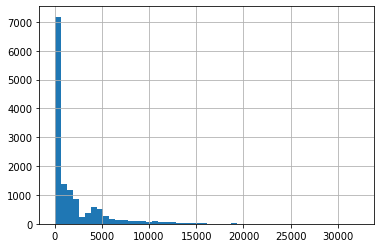

In [27]:
parldata["text_strip"].apply(len).hist(bins=50)

<AxesSubplot:>

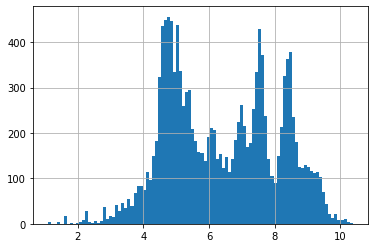

In [28]:
parldata["text_strip"].apply(len).apply(lambda x: np.log(x) if x != 0 else None).hist(bins=100)

In [29]:
parldata = parldata.filter(["speaker","speaker_party","type","text_strip","oldal","date"])

In [30]:
parldata.to_csv(data_dir + "input/parlament_speech_2020.csv", index=False)

## scrape representative name list

In [31]:
tables = pd.read_html(
    "https://hu.wikipedia.org/wiki/2018%E2%80%932022_k%C3%B6z%C3%B6tti_magyar_orsz%C3%A1ggy%C5%B1l%C3%A9si_k%C3%A9pvisel%C5%91k_list%C3%A1ja"
)

In [32]:
names = pd.concat(
    [
        tables[3],
        tables[4],
        tables[5],
    ]
)

names = names.dropna(subset=["Név"])
names["Név"] = names["Név"].str.split("[").apply(lambda x: x[0])
names = names[["Frakció","Mandátum kezdete","Mandátum vége","Név","Választókerület"]]

In [33]:
names.to_csv(data_dir + "input/representative_names_2018-2020.csv")

## scrape vote outcomes in the 2018 parliamentary elections

In [34]:
resp = requests.get("https://valtor.valasztas.hu/valtort/jsp/mkiv.jsp?EA=38&URL=7")
soup = BeautifulSoup(resp.content)

In [35]:
counties = ["https://valtor.valasztas.hu/valtort/jsp/" + i.get("href") for i in soup.find_all("a")]

In [36]:
constit = []
for county in counties:
    resp = requests.get(county)
    soup = BeautifulSoup(resp.content)
    constit = constit + [
        "https://valtor.valasztas.hu/valtort/jsp/" + i.get("href")
        for i in soup.find_all("a")
    ]

In [37]:
df = pd.DataFrame()

for const in constit:

    resp = requests.get(const)
    soup = BeautifulSoup(resp.content)

    df_c = pd.concat(pd.read_html(str(soup.find_all("table")[-1]), header=0))
    df_c["const"] = " ".join(
        [
            soup.find_all("font", {"size": 4})[1].get_text(),
            soup.find_all("font", {"size": 3})[1].get_text(),
        ]
    )
    df = pd.concat([df, df_c])
    
df["const"] = df["const"].str.replace("A választás eredményes", "BUDAPEST")

In [38]:
df.to_csv(data_dir +"input/vote_outcomes_2018.csv")